<a href="https://colab.research.google.com/github/maintain0404/DeepLearningStudy/blob/master/Chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 유방암 종양 정상/비정상 구분 데이터 샘플 가져오기
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
cancer = load_breast_cancer()

In [4]:
# 입력 데이터 확인하기
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


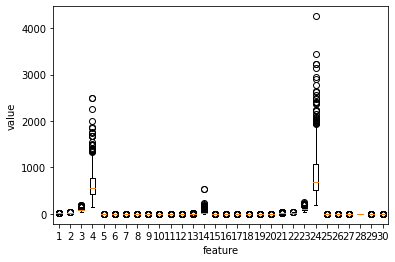

In [5]:
# 박스 플룻으로 특성의 사분위 값 확인하기
plt.boxplot(cancer.data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [6]:
# 타깃 데이터 살펴보기
# 눈에 띄는 특성
print(cancer.feature_names[[3,13,23]])
# 타깃 데이터 종류와 횟수 확인
print(np.unique(cancer.target, return_counts = True))

['mean area' 'area error' 'worst area']
(array([0, 1]), array([212, 357]))


In [7]:
# 훈련, 테스트 데이터 세트 나누기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify = cancer.target, test_size = 0.2, random_state=42)
# stratify = 결과 비율을 균일하게 만들기, 불균형한 경우 타깃을 지정해야 함
# test_size = 테스트 세트의 비율, 기본 0.25
# 난수 시드값

In [8]:
# 확인하기
print(x_train.shape, x_test.shape)
print(np.unique(y_train, return_counts = True))

(455, 30) (114, 30)
(array([0, 1]), array([170, 285]))


In [9]:
# 로지스틱 회귀 유닛 구현
class LogisticUnit:
  def __init__(self):
    self.w = None
    self.b = None
    self.zmax = 0

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b # np.sum은 행렬합을 ㅖ산함
    return z
  
  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    # a = 1 / (1 + np.exp(-z, dtype=np.float64)) # np.exp는 자연상수 e의 지수함수
    # return a

    # exp에서 overflow가 발생하여 수정함
    # z < e^max
    # ln(z) < max
    z = -z
    if z > np.log(np.finfo(z.dtype).max):
      return 0.0
    else:
      return 1 / (1 + np.exp(z))
    
  # 훈련 메소드
  def fit(self, x, y, epochs=100):
    # 초기화
    self.w = np.ones(x.shape[1])
    self.b = 0

    for i in range(epochs):
      for x_i, y_i in zip(x, y):
        z = self.forpass(x_i) # 정방향 계산
        a = self.activation(z) # 활성화 함수 계산
        err = -(y_i - a) # 오차 계산
        w_grad, b_grad = self.backprop(x_i, err) # 오차역전파
        self.w -= w_grad
        self.b -= b_grad
  
  # 유닛의 예측 메소드, 데이터가 2차원 배열로 여러 케이스가 들어올 때
  def predict(self, x):
    # 책 코드 원본
    # z = [self.forpass(x_i) for x_i in x] # 선형 회귀
    # a = self.activation(np.array(z))  # 활성화 함수
    # return a

    # 책 코드 수정
    z = [self.forpass(x_i) for x_i in x]
    a = list(map(lambda x: self.activation(x) > 0.5, z))  
    return np.array(list(a)) # 계단 함수

In [10]:
# 훈련
unit = LogisticUnit()
unit.fit(x_train, y_train)

In [11]:
# 훈련 정확도 평가
unit.predict(x_test)
np.mean(unit.predict(x_test) == y_test)

0.8245614035087719

In [22]:
# 단일층 신경망 구현하기
class SingleLayer:
  def __init__(self):
    self.w = None
    self.b = None
    self.zmax = 0
    self.losses = []

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b # np.sum은 행렬합을 ㅖ산함
    return z
  
  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    # a = 1 / (1 + np.exp(-z, dtype=np.float64)) # np.exp는 자연상수 e의 지수함수
    # return a

    # exp에서 overflow가 발생하여 수정함
    # z < e^max
    # ln(z) < max
    z = -z
    if z > np.log(np.finfo(z.dtype).max):
      return 0.0
    else:
      return 1 / (1 + np.exp(z))
    
  # 훈련 메소드
  def fit(self, x, y, epochs=100):
    # 초기화
    self.w = np.ones(x.shape[1])
    self.b = 0

    # 미니 배치 경사 하강법 적용
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 에포크마다 순서를 무작위로 섞음
      for j in indexes:
        z = self.forpass(x[j])
        a = self.activation(z)
        err = -(y[j] - a)
        w_grad, b_grad = self.backprop(x[j], err)
        self.w -= w_grad
        self.b -= b_grad
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[j] * np.log(a) + (1 - y[j]) * np.log(1-a)) # 손실을 누적시킴
      self.losses.append(loss/len(y)) # 에포크 당 평균 손실을 저장
  
  # 유닛의 예측 메소드, 데이터가 2차원 배열로 여러 케이스가 들어올 때
  def predict(self, x):
    # z가 0보다 크면 시그모이드에선 0.5보다 크고, 아니라면 0.5보다 작음
    # 훈련에서는 무한 범위를 좁히기 위해 필요하지만
    # 예측에서는 굳이 시그모이드를 쓸 필요가 없음
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0 # 계단 함수

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

In [23]:
# 훈련 및 예측률 보기
layer = SingleLayer()
layer.fit(x_train, y_train)
layer.score(x_test, y_test)

0.9210526315789473

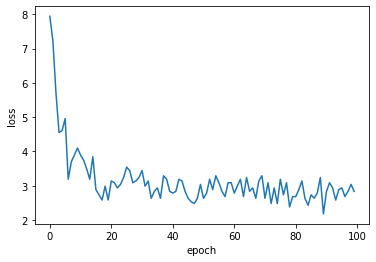

In [24]:
# 에포크당 평균 손실로 훈련 진행 확인하기
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [26]:
from sklearn.linear_model import SGDClassifier
# 사이킷런 경사 하강법 클래스

In [37]:
sgd = SGDClassifier(loss ='log', max_iter=1000, tol=1e-3, random_state = 42)
# tol만큼 손실이 일어나지 않으면 반복 중단

In [38]:
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

In [36]:
sgd.predict(x_test)

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1])